# Peter Micciche Lab 3

## Part 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = np.loadtxt('atlas_z_to_ll.csv', delimiter = ',', skiprows=1)

array([ 15.,  17.,  26.,  27.,  26.,  30.,  35.,  27.,  63.,  48.,  67.,
        60.,  74., 107., 128., 129., 179., 201., 230., 258., 232., 262.,
       215., 205., 194., 147., 145., 105.,  99.,  50.,  60.,  45.,  45.,
        27.,  24.,  25.,  13.,  14.,  21.,  22.])

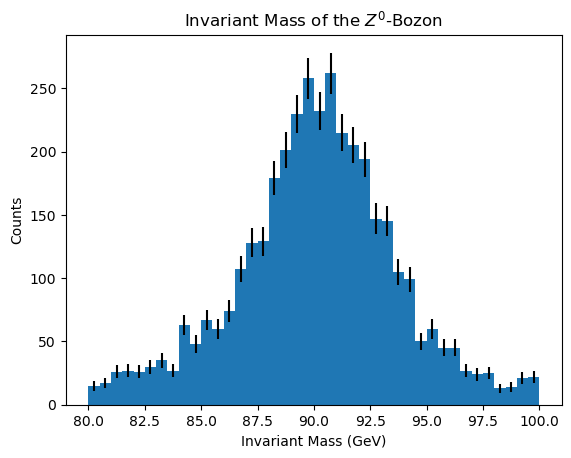

In [2]:
# columns:    pT1    pT2     eta1    eta2    phi1    phi2    E1    E2

pt1 = df[:,0]
pt2 = df[:,1]
eta1 = df[:,2]
eta2 = df[:,3]
phi1 = df[:,4]
phi2 = df[:,5]
E1 = df[:,6]
E2 = df[:,7]

def M(pt1, pt2, eta1, eta2, phi1, phi2, E1, E2):
    px1 = pt1 * np.cos(phi1)
    px2 = pt2 * np.cos(phi2)
    pxtot = px1 + px2
    py1 = pt1 * np.sin(phi1)
    py2 = pt2 * np.sin(phi2)
    pytot = py1 + py2
    pz1 = pt1 * np.sinh(eta1)
    pz2 = pt2 * np.sinh(eta2)
    pztot = pz1 + pz2
    p2tot = pxtot**2 + pytot**2 + pztot**2
    Etot = E1 + E2

    M = np.sqrt(Etot**2 - (p2tot))
    return M

M_calc = M(pt1, pt2, eta1, eta2, phi1, phi2, E1, E2)

fig, ax = plt.subplots()
bins = np.linspace(80,100,41)
hist = ax.hist(M_calc, bins=bins);
bin_centers = (bins[:-1] + bins[1:]) / 2
yerr = ax.errorbar(bin_centers, hist[0], np.sqrt(hist[0]), fmt=',k')
ax.set_xlabel('Invariant Mass (GeV)')
ax.set_title(r'Invariant Mass of the $Z^0$-Bozon')
ax.set_ylabel('Counts');

hist[0]

# Part 2

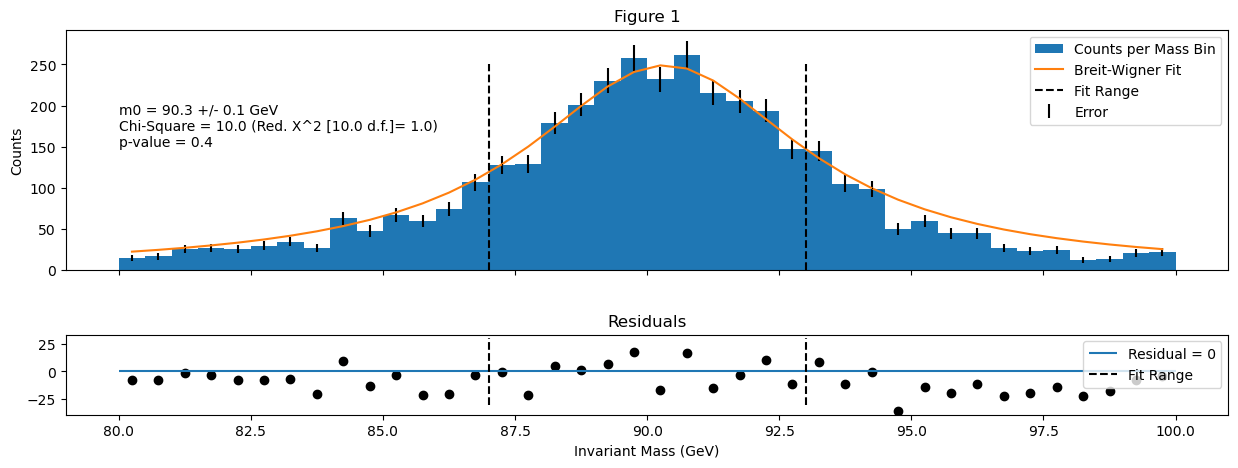

In [3]:
mZ0 = 91.1880   # GeV / c^2
from scipy.optimize import curve_fit

def D(m, m0, gamma):
    return 2500 * ((1/np.pi) * (gamma/2)/((m-m0)**2 + (gamma/2)**2))

err = np.sqrt(hist[0])

mask = (bin_centers > 87) & (bin_centers < 93)
bins_fit = bin_centers[mask]
hist_fit = hist[0][mask]
err_fit = err[mask]

params, covar = curve_fit(D, bins_fit, hist_fit, sigma=err_fit, absolute_sigma=True)

fig, (ax, ax_bot) = plt.subplots(2, 1, sharex=True, figsize=(15,5), gridspec_kw={'height_ratios': [3,1], 'hspace': 0.4})
bins = np.linspace(80,100,41)
hist = ax.hist(M_calc, bins=bins, label='Counts per Mass Bin');
bin_centers = (bins[:-1] + bins[1:]) / 2
ax.errorbar(bin_centers, hist[0], np.sqrt(hist[0]), fmt=',k', label = 'Error')
ax_bot.set_xlabel('Invariant Mass (GeV)')
ax.set_title('Figure 1')
ax.set_ylabel('Counts')

data_real = hist[0]
data_fit = D(bin_centers, params[0], params[1])
data_fit_masked = data_fit[mask]

ax.plot(bin_centers, data_fit, label='Breit-Wigner Fit')

resid = data_real - data_fit
ax_bot.plot(bin_centers, resid, 'ok')
ax_bot.set_title('Residuals')
ax_bot.hlines(0,80,100, label='Residual = 0')
ax_bot.vlines((87, 93), -30, 30, linestyle='--', color='k', label='Fit Range')
ax.vlines((87, 93), 0, 250, linestyle='--', color='k', label='Fit Range')
ax.legend()
ax_bot.legend();

import scipy.stats as st

chisq = np.sum(((hist_fit-data_fit_masked)/err_fit)**2)
dof = len(hist_fit) - 2
red_chisq = chisq/dof
p_val = st.chi2.sf(chisq, dof)

uncert = np.sqrt(np.diag(covar))

ax.text(80, 150, f'm0 = {params[0]:.1f} +/- {uncert[0]:.1f} GeV\nChi-Square = {chisq:.1f} (Red. X^2 [{dof:.1f} d.f.]= {red_chisq:.1f})\np-value = {p_val:.1f}');

# plt.savefig('Fig1.png')

In [4]:
print(f'The Chi-Square is {chisq:.4f}\nThe Reduced Chi-Square (with {dof:.0f} degrees of freedom) is {red_chisq:.4f}\nThe P Value is {p_val:.2f}')

The Chi-Square is 9.9851
The Reduced Chi-Square (with 10 degrees of freedom) is 0.9985
The P Value is 0.44


In [5]:
print(f'The best fit mass m0 is {params[0]:.4f} GeV with an uncertainty of {uncert[0]:.4f} GeV')

The best fit mass m0 is 90.3408 GeV with an uncertainty of 0.0935 GeV


# Part 3

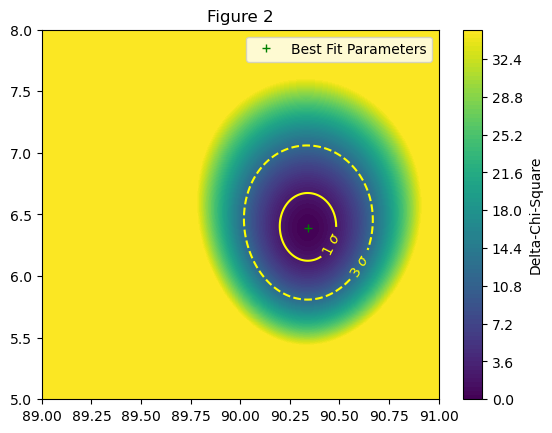

In [6]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

n = 300
chi_map = np.zeros((n, n))
M0 = np.linspace(89,91,n)
GAMMA = np.linspace(5,8,n)

for i in range(n):
    for j in range(n):
        theory = D(bins_fit, M0[i], GAMMA[j])
        chi2 = np.sum((data_fit_masked - theory)**2/err_fit**2)
        chi_map[j,i] = chi2

chi_min = np.min(chi_map)
delta_chi_map = chi_map - chi_min
delta_chi_map = np.clip(delta_chi_map, 0, 35)

X, Y = np.meshgrid(M0, GAMMA)

fig3, ax3 = plt.subplots()
ax3.set_title('Figure 2')
cs = ax3.contourf(M0, GAMMA, delta_chi_map, levels=100, cmap='viridis')
cbar = fig3.colorbar(cs, ax=ax3, label='Delta-Chi-Square')

levels=[2.30, 11.83]
CS = ax3.contour(M0,GAMMA,delta_chi_map, levels=levels, colors=['yellow','yellow'],
                 linestyles=['solid','dashed'])
ax.clabel(CS, fmt={2.30:r'1 $\sigma$', 11.83:r'3 $\sigma$'});

ax3.plot(params[0], params[1], 'g+', label='Best Fit Parameters');
ax3.legend();

# plt.savefig('Fig2.png')